In [8]:
import warnings
from typing import Any
import joblib
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score, auc

from utils import plot_roc
import ml_utils as utils
from ml_utils import get_weights_for_roc_auc, weighted_roc_metric, get_optimal_trs, plot_roc, get_tpr_fpr, plot_roc_curves
import train


np.random.seed(42)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [ ]:
target = "target"
dt_col = "dt"
min_test_date = "2020-10-14"
min_train_date = "2014-03-17"

# datasets
dataset_type_6_test = "magn_6_aft_test"
dataset_type_6_without_test = "magn_6_withoutaft_test"
dataset_type_3_5_test = "magn_3_5_aft_test"
dataset_type_3_5_without_test = "magn_3_5_withoutaft_test"

dataset_type_6_train = "magn_6_aft"
dataset_type_6_without_train = "magn_6_withoutaft"
dataset_type_3_5_train = "magn_3_5_aft_train"
dataset_type_3_5_without_train = "magn_3_5_withoutaft_train"

test_6_path = f"data/dataset/{dataset_type_6_test}.parquet"
test_6_without_path = f"data/dataset/{dataset_type_6_without_test}.parquet"
test_3_5_path = f"data/dataset/{dataset_type_3_5_test}.parquet"
test_3_5_without_path = f"data/dataset/{dataset_type_3_5_without_test}.parquet"

train_6_path = f"data/dataset/{dataset_type_6_train}.parquet"
train_6_without_path = f"data/dataset/{dataset_type_6_without_train}.parquet"
train_3_5_path = f"data/dataset/{dataset_type_3_5_train}.parquet"
train_3_5_without_path = f"data/dataset/{dataset_type_3_5_without_train}.parquet"

# models
aft_6_lgbm = "data/models/aft_6_lgbm.pickle"
withoutaft_6_lgbm = "data/models/withoutaft_6_lgbm.pickle"
aft_3_5_lgbm = "data/models/aft_3_5_lgbm.pickle"
withoutaft_3_5_lgbm = "data/models/withoutaft_3_5_lgbm.pickle"

# config_dict
config_dict = {
    "aft_3_5": {
        "name": "magnitude > 3.5 | with aftershocks",
        "train": train_3_5_path,
        "test": test_3_5_path,
        "model": aft_3_5_lgbm,
    },
    "withoutaft_3_5": {
        "name": "magnitude > 3.5 | without aftershocks",
        "train": train_3_5_without_path,
        "test": test_3_5_without_path,
        "model": withoutaft_3_5_lgbm,
    },
    "aft_6": {
        "name": "magnitude > 6 | with aftershocks",
        "train": train_6_path,
        "test": test_6_path,
        "model": aft_6_lgbm,
    },
    "withoutaft_6": {
        "name": "magnitude > 6 | without aftershocks",
        "train": train_6_without_path,
        "test": test_6_without_path,
        "model": withoutaft_6_lgbm,
    },
}

In [10]:
config_dict

{'aft_3_5': {'name': 'magnitude > 3.5 | with aftershocks',
  'train': 'data/dataset/magn_3_5_aft_train.parquet',
  'test': 'data/dataset/magn_3_5_aft_test.parquet',
  'model': 'data/models/aft_3_5_lgbm.pickle'},
 'withoutaft_3_5': {'name': 'magnitude > 3.5 | without aftershocks',
  'train': 'data/dataset/magn_3_5_withoutaft_train.parquet',
  'test': 'data/dataset/magn_3_5_withoutaft_test.parquet',
  'model': 'data/models/withoutaft_3_5_lgbm.pickle'},
 'aft_6': {'name': 'magnitude > 6 | with aftershocks',
  'train': 'data/dataset/magn_6_aft.parquet',
  'test': 'data/dataset/magn_6_aft_test.parquet',
  'model': 'data/models/aft_6_lgbm_.pickle'},
 'withoutaft_6': {'name': 'magnitude > 6 | without aftershocks',
  'train': 'data/dataset/magn_6_withoutaft.parquet',
  'test': 'data/dataset/magn_6_withoutaft_test.parquet',
  'model': 'data/models/withoutaft_6_lgbm_.pickle'}}

In [11]:
# plot all types, weighted roc
fpr_tpr_dict = {}
for data_type in config_dict:
        
    TEST_PATH = config_dict[data_type]["test"]
    TRAIN_PATH = config_dict[data_type]["train"]
    MODEL_PATH = config_dict[data_type]["model"]

    _, test_df = utils.get_train_test_datasets(
        train_path=TRAIN_PATH, test_path=TEST_PATH, 
        min_test_date = min_test_date, min_train_date = min_train_date
    )
    
    feature_cols = list(set(test_df.columns) - set([target, dt_col, "horizon_min_dt", "horizon_max_dt"]))
    
    # train, test
    features = utils.Features(
        features=feature_cols, target=target, dt_col=dt_col, 
        groupby=["cell_x", "cell_y"], target_features=[]
    )
    
    X_test, y_test = features.make_features_target(test_df)
    y_test = y_test[target]
    roc_auc_weights_test = get_weights_for_roc_auc(y=y_test, last_dt=min_test_date, trs=3.0)
    
    lgbm_model = joblib.load(open(MODEL_PATH, "rb"))
    y_pred_prob = lgbm_model.predict_proba(X_test)
    n, N, tpr, fpr = get_tpr_fpr(y_test, y_pred_prob[:, 1], sample_weight=roc_auc_weights_test, n=1000, return_alarm_rate=True)
    fpr_tpr_dict[data_type] = {"tpr": tpr.copy(), "fpr": fpr.copy(), "n": n, "N": N}

train_path: data/dataset/magn_3_5_aft_train.parquet
test_path: data/dataset/magn_3_5_aft_test.parquet


train dates: 2014-03-21 — 2020-08-26
test dates: 2020-10-14 — 2023-05-21

train: target==0: 1593709, target==1: 27847
test: target==0: 6428932, target==1: 98518
target class proportion: test: 0.015324162706962836, train: 0.01747307695445028


train_path: data/dataset/magn_3_5_withoutaft_train.parquet
test_path: data/dataset/magn_3_5_withoutaft_test.parquet


train dates: 2014-03-20 — 2020-08-25
test dates: 2020-10-14 — 2023-05-21

train: target==0: 2318668, target==1: 8292
test: target==0: 6453815, target==1: 41093
target class proportion: test: 0.006367241701226329, train: 0.003576191158026936


train_path: data/dataset/magn_6_aft.parquet
test_path: data/dataset/magn_6_aft_test.parquet


train dates: 2014-03-20 — 2020-08-25
test dates: 2020-10-14 — 2023-05-21

train: target==0: 2326760, target==1: 200
test: target==0: 9366239, target==1: 761
target class proportion: test: 8.124926130968898e-05, train: 8.595643727758772e-05


train_path: data/dataset/magn_6_withoutaft.parquet
test_path: data/dataset/magn_6_withoutaft_test.parquet


train dates: 2014-03-20 — 2020-08-25
test dates: 2020-10-14 — 2023-05-21

train: target==0: 2326860, target==1: 100
test: target==0: 9366468, target==1: 532
target class proportion: test: 5.67983577160569e-05, train: 4.297637159089932e-05


In [12]:
! rm -rf data/models/lgbm_fpr_tpr.json

In [13]:
with open("data/models/lgbm_fpr_tpr.json", 'w') as json_file:
    json.dump(fpr_tpr_dict, json_file, indent=4, cls=NpEncoder)

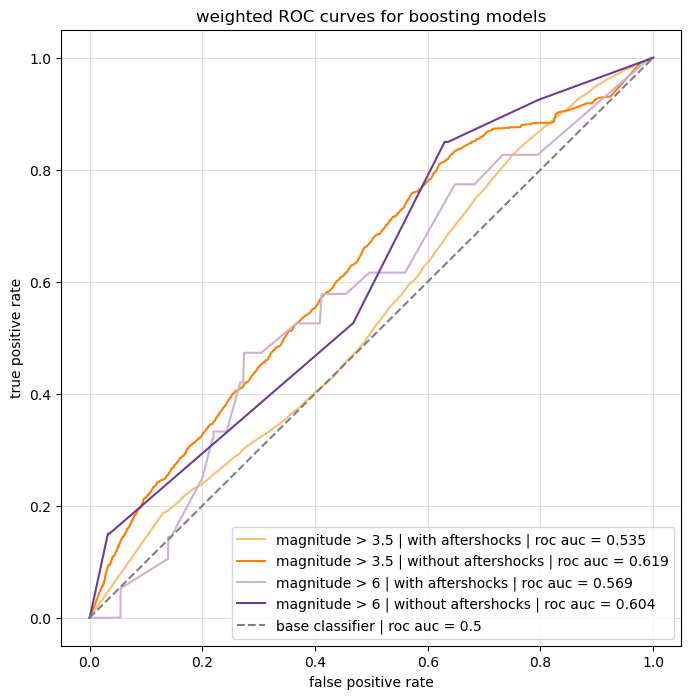

In [14]:
# Plotting the ROC curves
fpr_tpr_dict = json.load(open("data/models/lgbm_fpr_tpr.json", 'r'))
colors = plt.cm.Paired(range(6, 6+len(fpr_tpr_dict)))

plt.figure(figsize=(8, 8), dpi=100)

for data_type, values in fpr_tpr_dict.items():
    fpr, tpr = values["fpr"], values["tpr"]
    roc_auc_w = round(auc(fpr, tpr), 3)
    label = f"{config_dict[data_type]['name']} | roc auc = {roc_auc_w}"
    plt.plot(fpr, tpr, color=colors[list(fpr_tpr_dict.keys()).index(data_type)], label=label)

# ROC curve data for a random classifier
fpr_random, tpr_random = [0, 1], [0, 1]
plt.plot(fpr_random, tpr_random, c="grey", ls='--', label = "base classifier | roc auc = 0.5")

# Adding legend and grid
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('weighted ROC curves for boosting models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.4)
plt.show();